In [157]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from scipy.integrate import nquad, quad
from scipy.interpolate import interp1d
from scipy.special import erf, jn, jv, kn
import mpmath as mp
from skmonaco import mcimport, mcquad, mcmiser
import matplotlib.pylab as pylab
from cycler import cycler
import palettable

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
params = {'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['CMU Serif'],
          'font.sans-serif': ['CMU Sans Serif'],
          'legend.fontsize': 17,
          'legend.fancybox': True,
          'legend.frameon': False,
          'legend.framealpha': 0.4,
          'legend.labelspacing': 0.5,
          'figure.figsize': (6.4/1.1, 4.8/1.1),
          'axes.labelsize': 19,
          'axes.titlesize':18,
          'axes.titlepad':10,
          'axes.linewidth':1.1,
          'axes.labelpad':10,
          'axes.prop_cycle': cycler('color', palettable.cartocolors.qualitative.Bold_10.hex_colors) + 
                            cycler(alpha=10*[.7]), 
          'lines.linewidth':2.5,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 5,
          'xtick.minor.size': 2,
          'ytick.major.size': 5,
          'ytick.minor.size': 2,
          'xtick.major.width': 1,
          'ytick.major.width': 1,
          'xtick.minor.width': 0.8,
          'ytick.minor.width': 0.8,
         }
pylab.rcParams.update(params)

In [350]:
plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/draft/plots/"

In [160]:
alpha_plot = 0.8
lw_plot = 2.5
colors_plot = ['dodgerblue', 'orange', 'mediumorchid']

In [161]:
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

# Sensitivity to compact objects

In [470]:
def get_f_DM_lim(M_DM=1e8*M_s, R0_DM=0, sigma_mu = 1, sigma_alpha = None,
                 N_q_mu = 1e9, N_q_alpha = 1e9, 
                 l_min_mu=10, l_max_mu=2000, l_min_alpha=10, l_max_alpha=2000, f_sky=1):
    
    l_max = max(l_max_mu, l_max_alpha)
    
    pspecpop = PowerSpectraPopulations(l_max=l_max)
    pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-3*kpc, R_max=10*kpc)
    pspecpop.set_mass_distribution_compact(M_DM=M_DM, f_DM=1,R0_DM=R0_DM)
    
    Cl_ary = pspecpop.get_C_l_compact_total_ary()
    
    if sigma_mu is not None:
        Cl_ary = pspecpop.get_C_l_compact_total_ary()
    else:
        Cl_ary = np.zeros(len(Cl_ary)) 

    if sigma_alpha is not None:
        Cl_ary_accel = pspecpop.get_C_l_compact_total_ary(accel=True)
    else:
        Cl_ary_accel = np.zeros(len(Cl_ary)) 
        
    fDM_base = 0
    dfDM_base = 0.1

    Cl_ary_fid = np.array(Cl_ary)*fDM_base
    Cl_ary_accel_fid = np.array(Cl_ary_accel)*fDM_base

    p = np.array(Cl_ary)*(fDM_base + dfDM_base)
    m = np.array(Cl_ary)*(fDM_base - dfDM_base)

    p_a = np.array(Cl_ary_accel)*(fDM_base + dfDM_base)
    m_a = np.array(Cl_ary_accel)*(fDM_base - dfDM_base)

    fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                    p_a, m_a, l_min=1, l_max=l_max)

    parameters = [Cl_ary_fid, Cl_ary_accel_fid, 1, l_max, fDM]
    
    observation = AstrometryObservation(fsky=f_sky, sigma_mu=sigma_mu, sigma_alpha=sigma_alpha, 
                                        N_q_mu=N_q_mu, N_q_alpha=N_q_alpha, 
                                        l_min_mu=l_min_mu, l_max_mu=l_max_mu, l_min_alpha=l_min_alpha, l_max_alpha=l_max_alpha)

    fshr = FisherForecast(parameters, observation)
    lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])

    return lim, fshr

In [467]:
def get_f_DM_lim_simple(M_DM=1e8*M_s, R0_DM=0, sigma=1,
                 N_q = 1e9,
                 l_min=2, l_max=2000, f_sky=1):
        
    pspecpop = PowerSpectraPopulations(l_max=l_max)
    pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-3*kpc, R_max=10*kpc)
    pspecpop.set_mass_distribution_compact(M_DM=M_DM, f_DM=1,R0_DM=R0_DM)
    
    
    if accel:
        Cl_ary = pspecpop.get_C_l_compact_total_ary(accel=True)
    else:
        Cl_ary = pspecpop.get_C_l_compact_total_ary()
        
    Nl_ary = 4 * np.pi * sigma_mu ** 2 / N_q
    
    l_ary = np.arange(l_min, l_max)
    
    F = f_sky * (l_ary + 0.5) * (Cl_ary / (Cl_ary + Nl_ary)) ** 2
    
    lim = 1.64 * np.sqrt(np.sum(F))
    
    return lim, fshr

In [474]:
M_DM_ary = np.logspace(1.5,10,10)*M_s

f_DM_lim_1_ary = [get_f_DM_lim(M_DM, sigma_mu=1, sigma_alpha=.1, N_q=1e8, l_max_mu=2000, l_max_alpha=2000)[0] for M_DM in tqdm_notebook(M_DM_ary)]
f_DM_lim_2_ary = [get_f_DM_lim(M_DM, sigma_mu=1, sigma_alpha=.1, N_q=1e8,l_max_mu=10000,l_max_alpha=10000)[0] for M_DM in tqdm_notebook(M_DM_ary)]
f_DM_lim_3_ary = [get_f_DM_lim(M_DM, R0_DM=10*pc, sigma_mu=1, sigma_alpha=.1, N_q=1e8,l_max_mu=2000,l_max_alpha=2000)[0] for M_DM in tqdm_notebook(M_DM_ary)]


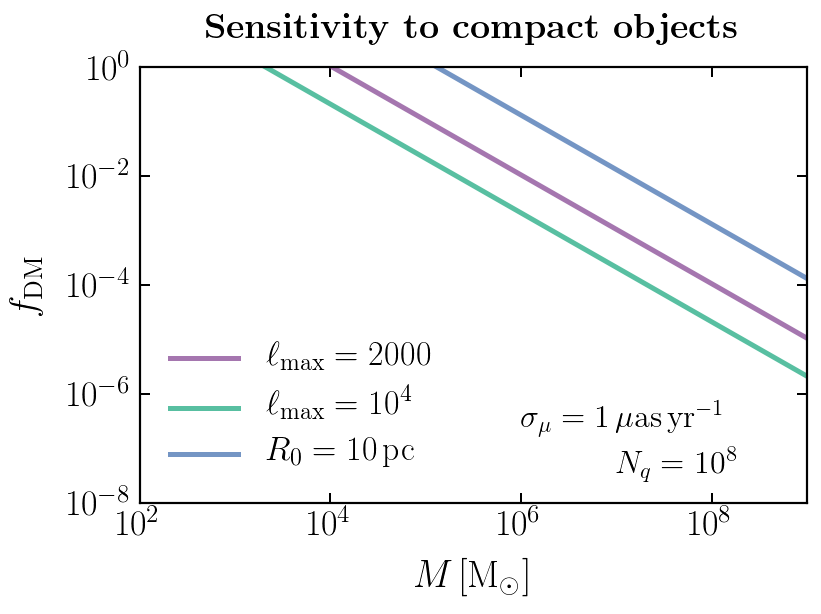

In [476]:
plt.plot(M_DM_ary/M_s, f_DM_lim_1_ary, label='$\ell_\mathrm{max} = 2000$')
plt.plot(M_DM_ary/M_s, f_DM_lim_2_ary, label='$\ell_\mathrm{max} = 10^4$')
plt.plot(M_DM_ary/M_s, f_DM_lim_3_ary, label='$R_0=10$\,pc')

plt.xscale("log")
plt.yscale("log")

plt.ylim(1e-8,1)
plt.xlim(1e2,1e9)

plt.xlabel("$M$\,[M$_\odot$]")
plt.ylabel("$f_\mathrm{DM}$")

plt.title('\\textbf{Sensitivity to compact objects}', y = 1.02, fontsize=18)
legend = plt.legend()
# plt.setp(legend.get_title(),fontsize=18)

plt.text(1e6, 2e-7, "$\sigma_\mu=1\,\mu$as\,yr$^{-1}$", fontsize=16)
plt.text(1e7, 3e-8, "$N_q = 10^8$", fontsize=16)

plt.tight_layout()
plt.savefig(plots_dir + "/compact.pdf")

In [388]:
m = 1e-18 * eV
m22 = (m / (1e-22 * eV))
M_DM = 5e5 * M_s * m22 ** -3  * (32/ 15) * np.pi ** 1.5 # 1e4*M_s
R0_DM =  58 * pc * m22 ** -1

print(np.log10(M_DM / M_s))
print(R0_DM / pc)

-5.22624646736
0.0058


In [453]:
m = 1e-21 * eV
m22 = (m / (1e-22 * eV))
M_DM = 5e5 * M_s * m22 ** -3  * (32/ 15) * np.pi ** 1.5 # 1e4*M_s
R0_DM =  58 * pc * m22 ** -1

M_DM = 1e4 * M_s # 1e4*M_s
R0_DM=  1e-2 * pc

sigma_mu = 1
sigma_alpha = 0.1

N_q_mu = 1e8
N_q_alpha = 1e12
lmax = 5e5

lim, fshr = get_f_DM_lim(M_DM=M_DM, sigma_mu=sigma_mu, R0_DM=R0_DM, sigma_alpha=None, N_q_mu=N_q_mu, N_q_alpha=N_q_alpha, 
                         l_min_mu=1, l_max_mu=lmax,l_min_alpha=1, l_max_alpha=lmax) 

# lim_alpha, fshr_alpha = get_f_DM_lim(M_DM=M_DM, sigma_mu=sigma_mu, R0_DM=R0_DM, sigma_alpha=sigma_alpha, N_q_mu=N_q_mu, N_q_alpha=N_q_alpha, 
#                          l_min_mu=1, l_max_mu=lmax,l_min_alpha=1, l_max_alpha=lmax) 

lim_only_alpha, fshr_only_alpha = get_f_DM_lim(M_DM=M_DM, sigma_mu=None, R0_DM=R0_DM, sigma_alpha=sigma_alpha, N_q_mu=N_q_mu, N_q_alpha=N_q_alpha, 
                         l_min_mu=1, l_max_mu=lmax,l_min_alpha=1, l_max_alpha=lmax, f_sky=0.02) 

# R0_DM=100*pc
# lim1, fshr1 = get_f_DM_lim(M_DM=1e6*M_s, sigma_mu=1, R0_DM=R0_DM, sigma_alpha=.1, N_q=1e8, l_min_mu=1, l_max_mu=2000,l_min_alpha=1, l_max_alpha=2000) 

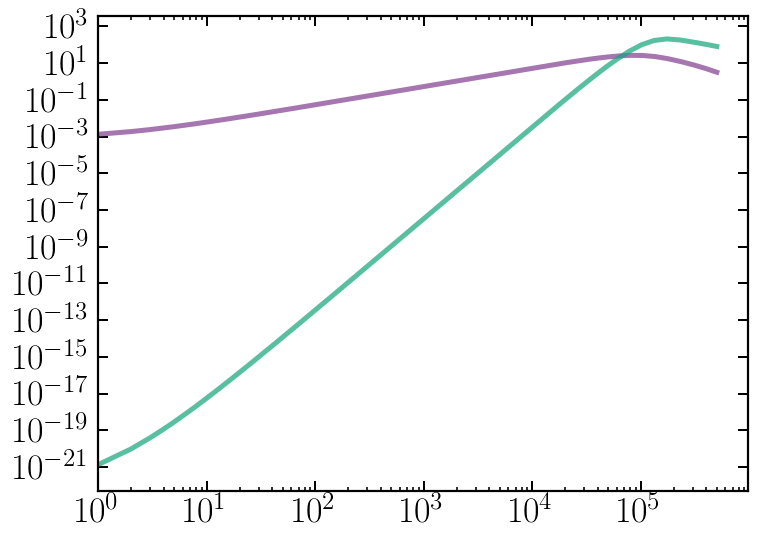

In [454]:
plt.plot(fshr.fshr_l[0][0])
# plt.plot(fshr_alpha.fshr_l[0][0])
plt.plot(fshr_only_alpha.fshr_l[0][0])
plt.xscale("log")
plt.yscale("log")
plt.xscale("log")
plt.yscale("log")

(10000.0, 200000.0)

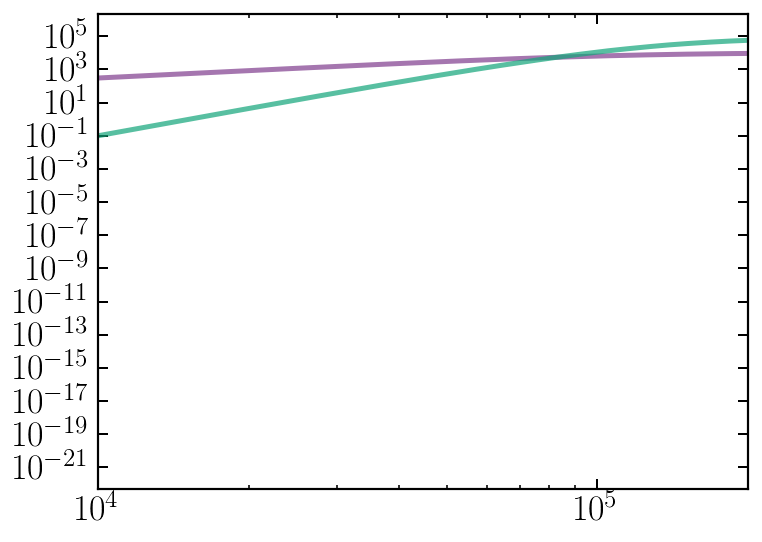

In [455]:
plt.plot(np.sqrt(np.cumsum(fshr.fshr_l[0][0]**2)))
# plt.plot(np.sqrt(np.cumsum(fshr_alpha.fshr_l[0][0]**2)))
plt.plot(np.sqrt(np.cumsum(fshr_only_alpha.fshr_l[0][0]**2)))
plt.xscale("log")
plt.yscale("log")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e4,2e5)

In [183]:
# l_ary = np.arange(1,len(fshr.fshr_l[0,0]) + 1)

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13/1.1,4/1.1))

# ax1.plot(l_ary, fshr.fshr_l[0,0], color='forestgreen', label='PS')
# ax1.plot(l_ary, fshr1.fshr_l[0,0], color='forestgreen',ls='--', label='$R_0=10$\,pc')
# ax1.axvline(1 * kpc / R0_DM, ls='--', color='grey', lw=1.5)
# ax1.axvline(10 * kpc / R0_DM, ls='--', color='grey', lw=1.5)
# # ax1.text(10** (np.log10(0.5 * kpc / R_0) + .05 ), 5e-3, '$0.5\,\mathrm{kpc}/R_0$',rotation=90, fontsize=14)
# # ax1.text(10** (np.log10(10 * kpc / R_0) + .05 ), 1e-4, '$10\,\mathrm{kpc}/R_0$',rotation=90, fontsize=14)

# ax1.set_xlabel('$\ell$')
# ax1.set_ylabel(r'$F_\ell^{\mu}$')
# ax1.set_xscale("log")
# ax1.set_yscale("log")
# ax1.set_title(r"\textbf{Fisher information, MW compact objects}")
# ax1.legend(fontsize=16)

# ax1.set_xlim(min(l_ary), max(l_ary))

# ax2.plot(np.sqrt(np.cumsum(fshr.fshr_l[0,0])), color='firebrick', label='PS')
# ax2.plot(np.sqrt(np.cumsum(fshr1.fshr_l[0,0])), color='firebrick', ls='--', label='$R_0=10$\,pc')
# ax2.axvline(1 * kpc / R0_DM, ls='--', color='grey', lw=1.5)
# ax2.axvline(10 * kpc / R0_DM, ls='--', color='grey', lw=1.5)
# # ax2.text(10** (np.log10(0.5 * kpc / R_0) + .05 ), 5e2, '$0.5\,\mathrm{kpc}/R_0$',rotation=90, fontsize=14)
# # ax2.text(10** (np.log10(10 * kpc / R_0) + .05 ), 6, '$10\,\mathrm{kpc}/R_0$',rotation=90, fontsize=14)

# ax2.set_xlabel('$\ell_\mathrm{max}$')
# ax2.set_ylabel('Significance $\sigma_\mathrm{sig}$')
# ax2.set_xscale("log")
# ax2.set_yscale("log")
# ax2.set_title(r"\textbf{Significance, MW compact objects}")
# ax2.set_xlim(min(l_ary), max(l_ary))
# ax2.legend(fontsize=16)

# plt.tight_layout()

# plt.savefig(plots_dir + "fisher_mu_mw.pdf")

In [471]:
M_ary = np.logspace(4,9,5) * M_s
R_ary = np.logspace(-1,4.5,5) * pc

In [ ]:
sig_ary = np.zeros((len(M_ary), len(R_ary)))
lim_ary = np.zeros((len(M_ary), len(R_ary)))

for iM, M in enumerate(tqdm_notebook(M_ary)):
    for iR, R in enumerate(R_ary):
        lim_ary[iM, iR] = get_f_DM_lim(M, R0_DM=R, sigma_mu=1, sigma_alpha=None, N_q_mu=1e8, l_max_mu=10000, l_max_alpha=10000)[0]

../../theory/spec_calc.py:462: RuntimeWarning: divide by zero encountered in log10
  else:


In [126]:
# lim_R = []
# for iM, M in enumerate((M_ary)):
#     lim_R.append(interp1d(lim_ary[iM], R_ary, bounds_error=False, kind='linear', fill_value='extrapolate')(1.) / pc)

In [468]:
lim_R = []
for iM, M in enumerate((M_ary)):
    lim_R.append(np.interp(1, lim_ary[iM], R_ary) / pc)

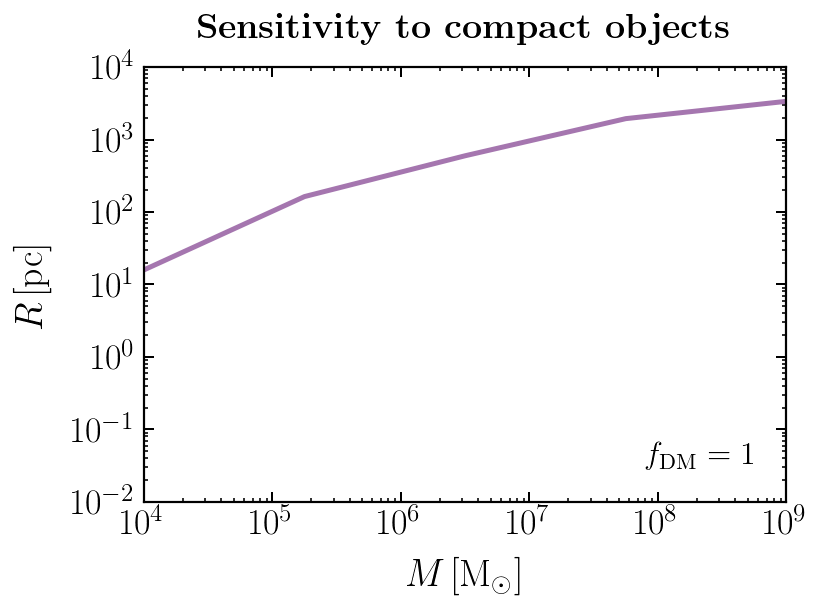

In [469]:
plt.plot(M_ary / M_s, np.array(lim_R))
plt.xscale("log")
plt.yscale("log")

plt.xlim(1e4,1e9)
plt.ylim(1e-2,1e4)

plt.xlabel("$M$\,[M$_\odot$]")
plt.ylabel("$R$\,[pc]")

plt.title('\\textbf{Sensitivity to compact objects}', y = 1.02, fontsize=18)

plt.tight_layout()
plt.text(8e7, 3e-2, "$f_\mathrm{DM} = 1$", fontsize=16)

plt.tight_layout()
# plt.savefig(plots_dir + "compact_M_vs_R.pdf")